# IMPORTANDO BIBLIOTECAS



In [196]:
import pandas as pd
import numpy as np

# visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix

import io

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 16})

# FUNÇÕES

## Visualização

In [150]:
def boxplot(df, x: str, y: str, labels: list):
    plt.figure(figsize=(12,6))
    ax = sns.boxplot(x=x, y=y, data = df, orient='h')
    ax.set_yticklabels(labels, size=16)
    plt.tight_layout()
    
    return None

In [151]:
def countplot(df, x: str, hue='cardio', labels=None):
    # analisando histogramas de variáveis quantitativas
    plt.figure(figsize=(15,6))
    ax = sns.countplot(data=df, x=x, hue=hue, palette="GnBu_d")
    plt.legend(['saudável', 'cardíaco'])
    
    
    if labels:
        ax.set_xticklabels(labels, size=16)
    
    plt.tight_layout()
    return None

In [152]:
def plot_correlation(df):
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='Blues', vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return None

## Dataframe Ops

In [153]:
def drop_queries(df, col, lmin:int, lmax:int, inplace=True):
    return (
        df.drop(
            df.query(f"({col} > @lmax) | ({col} < @lmin)")
            .index,
            inplace=inplace)
    )

def check_df(df):
    assert all(df.isna().sum())  == 0, 'The dataframe contains NaN files'
    assert df.duplicated().sum() == 0, 'The dataframe contains duplicates'
    return None

## Modelos

In [198]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()
    return None

# EXTRAÇÃO

##  Dataframe

In [154]:
DATA_DIR = 'data/cardio.csv'

In [155]:
df = pd.read_csv(DATA_DIR, sep=';')

print('Linhas: ', df.shape[0])
print('Colunas: ', df.shape[0])

df.head()

Linhas:  70000
Colunas:  70000


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Informações sobre cada coluna:

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

cardio: [Positivo (1) / Negativo (0)]

# TRANSFORMAÇÃO

Analisando se há arquivos do tipo NaN ou duplicatas no dataframe.


In [156]:
check_df(df)

alterando a idade para anos

In [157]:
df['age'] = np.floor(df['age'] / 365).astype(int)
df.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1


## Análises Exploratória dos Dados

### Variáveis quantitativas

#### Relação entre idade e pacientes saudáveis e cardíacos

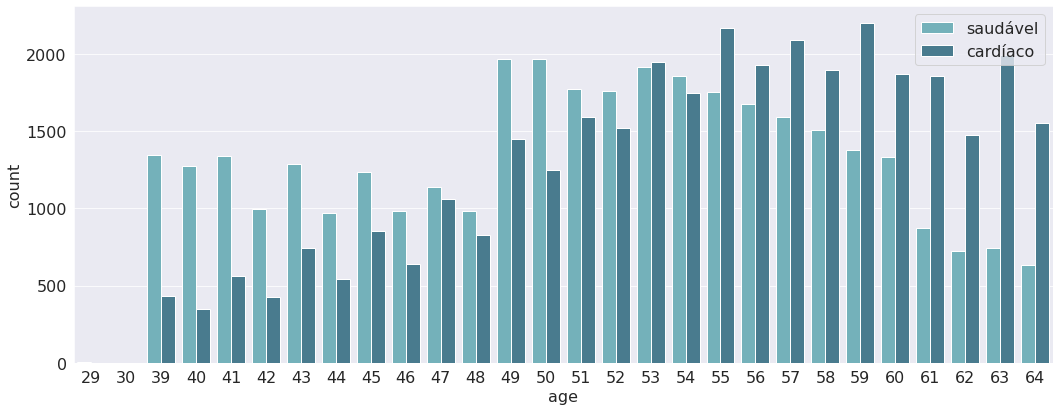

In [158]:
countplot(df, x='age')

✅ A partir dos 53 anos as pessoas já tendem a ter complicações. Aos 55 anos os pacientes cardíacos torna-se predominante.

Além de visualizarmos apenas a distribuição, vamos criar boxplots com as variáveis do dataframe. Dessa forma podemos ter uma melhor noção sobre os extremos, os quartis e a mediana de cada coluna do dataframe - com esses valores nós podemos identificar certos comportamentos anômalos nos dados, chamados de outliers.

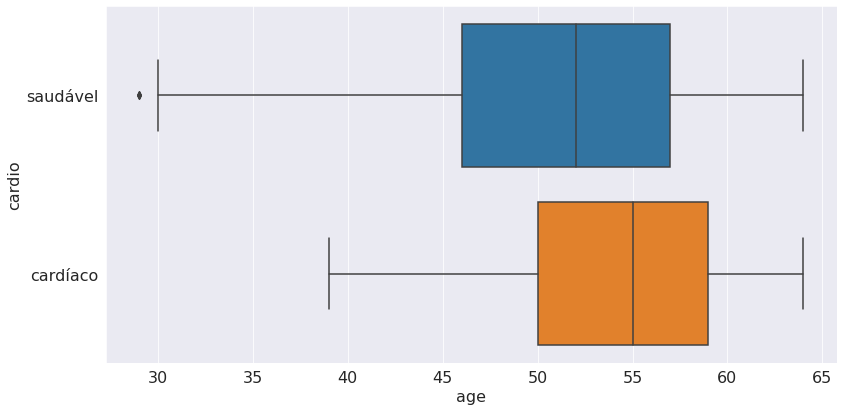

In [159]:
boxplot(df, x='age', y='cardio', labels=['saudável', 'cardíaco'])

✅ A mediana para os cardíacos é aproximadamente 55 anos.

✅ A tendência é que 75% dos pacientes cardíacos tenham idade acima de 50 anos.

#### Relação entre pressão sanguínea e pacientes saudáveis e cardíacos

##### **PRESSÃO ALTA**

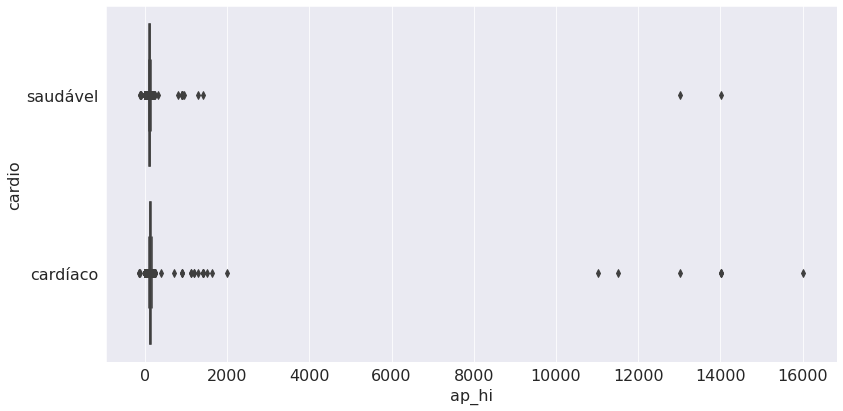

In [160]:
boxplot(df, x='ap_hi', y='cardio', labels=['saudável', 'cardíaco'])

❗ Encontramos outliers! Vamos considerar valores acima dos percentis de 95% e abaixo de 2% para valores de pressão sanguínea do conjunto de dados.

In [161]:
print('98% dos valores de ap_hi estão até o valor de {}'.format(df.ap_hi.quantile(0.98)))
print('2% dos valores de ap_hi estão até o valor de {}'.format(df.ap_hi.quantile(0.02)))

98% dos valores de ap_hi estão até o valor de 170.0
2% dos valores de ap_hi estão até o valor de 100.0


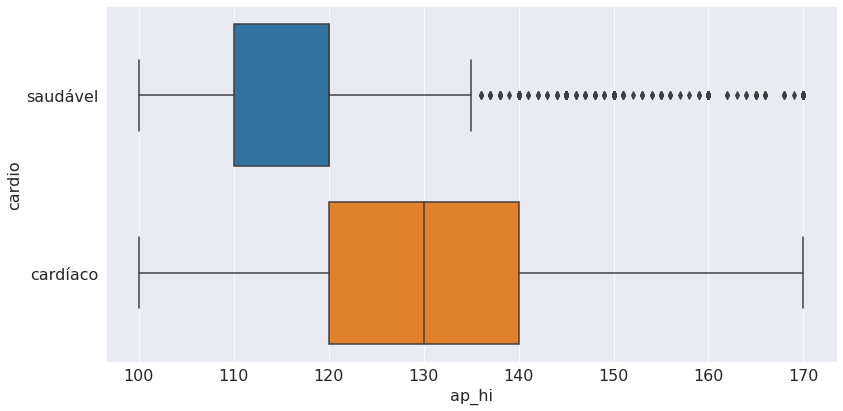

In [162]:
boxplot(df.query('(ap_hi >= 100) and (ap_hi <= 170)'), x='ap_hi', y='cardio', labels=['saudável', 'cardíaco'])

Removendo esses dados do dataframe original

In [163]:
print('shape antes de remover outliers:')
print('linhas:' ,df.shape[0])
print('colunas:' ,df.shape[1])

shape antes de remover outliers:
linhas: 70000
colunas: 13


In [164]:
# ap_hi maiores que 170 e menores que 100 serão eliminados do dataframe original
drop_queries(df, col='ap_hi', lmin=100, lmax=170, inplace=True)

In [165]:
print('shape após remover outliers:')
print('linhas:' ,df.shape[0])
print('colunas:' ,df.shape[1])

shape após remover outliers:
linhas: 67536
colunas: 13


**CONFERINDO O RESULTADO:**

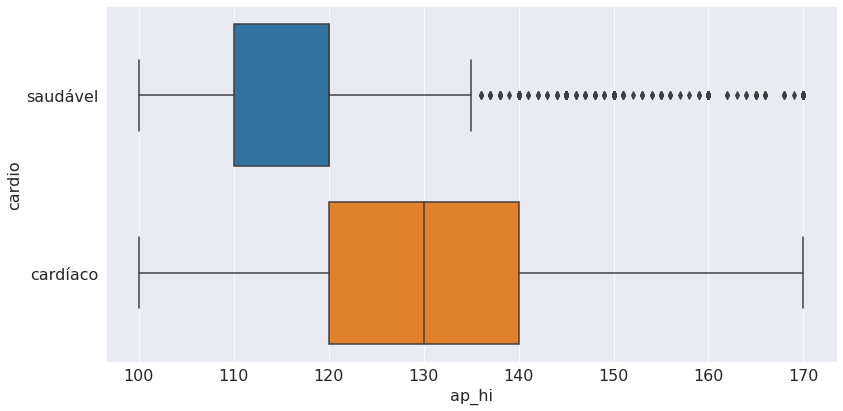

In [166]:
boxplot(df, x='ap_hi', y='cardio', labels=['saudável', 'cardíaco'])

##### PRESSÃO BAIXA

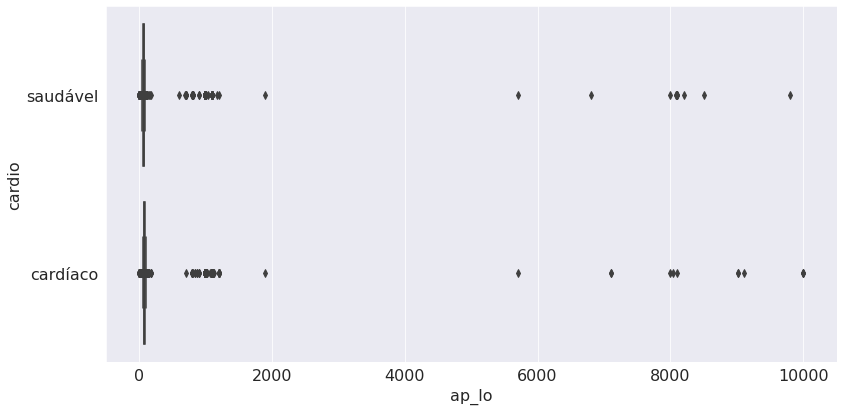

In [167]:
boxplot(df, x='ap_lo', y='cardio', labels=['saudável', 'cardíaco'])

In [168]:
print('98% dos valores de ap_lo estão até o valor de {}'.format(df.ap_lo.quantile(0.98)))
print('2% dos valores de ap_lo estão até o valor de {}'.format(df.ap_lo.quantile(0.02)))

98% dos valores de ap_lo estão até o valor de 100.0
2% dos valores de ap_lo estão até o valor de 60.0


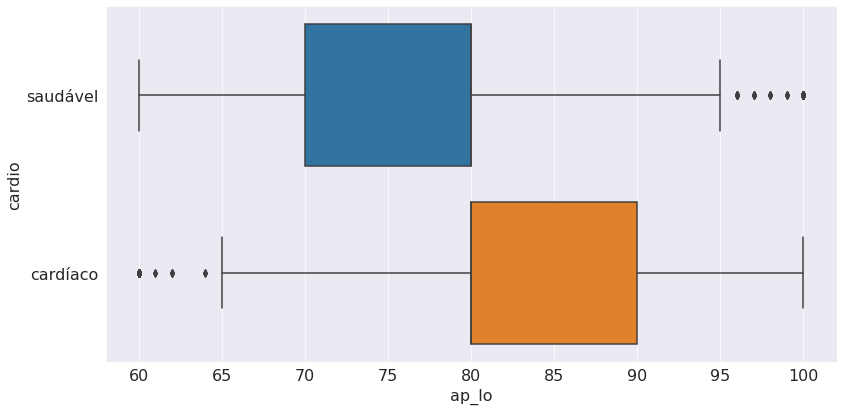

In [169]:
boxplot(df.query('(ap_lo >= 60) and (ap_lo <= 100)'), x='ap_lo', y='cardio', labels=['saudável', 'cardíaco'])

In [170]:
print('shape antes de remover outliers:')
print('linhas:' ,df.shape[0])
print('colunas:' ,df.shape[1])

shape antes de remover outliers:
linhas: 67536
colunas: 13


In [171]:
drop_queries(df, col='ap_lo', lmin=60, lmax=100, inplace=True)

In [172]:
print('shape após remover outliers:')
print('linhas:' ,df.shape[0])
print('colunas:' ,df.shape[1])

shape após remover outliers:
linhas: 66193
colunas: 13


**CONFERINDO O RESULTADO:**

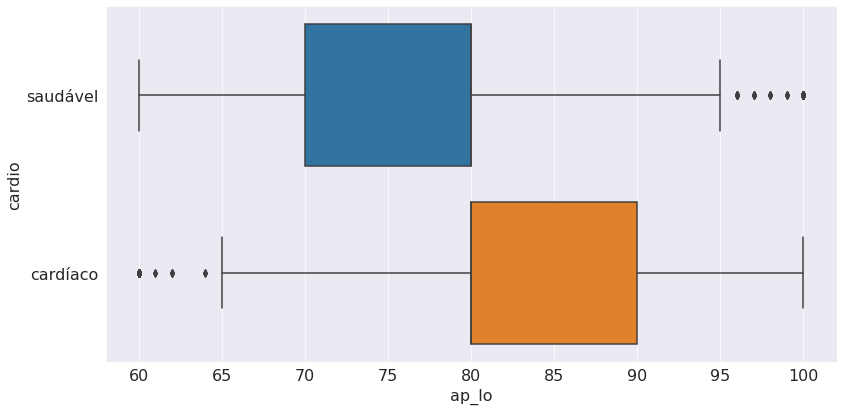

In [173]:
boxplot(df, x='ap_lo', y='cardio', labels=['saudável', 'cardíaco'])

❕ questões extra que podem influênciar no desempenho do modelo em caso de ser colocado em produção:

1. Não temos informações sobre os medicamentos que os pacientes estão utilizando. Pode haver medicamentos que causam aumento ou redução da pressão.

2. Problema cardíaco mais grave pode apresentar uma pressão mais baixa.

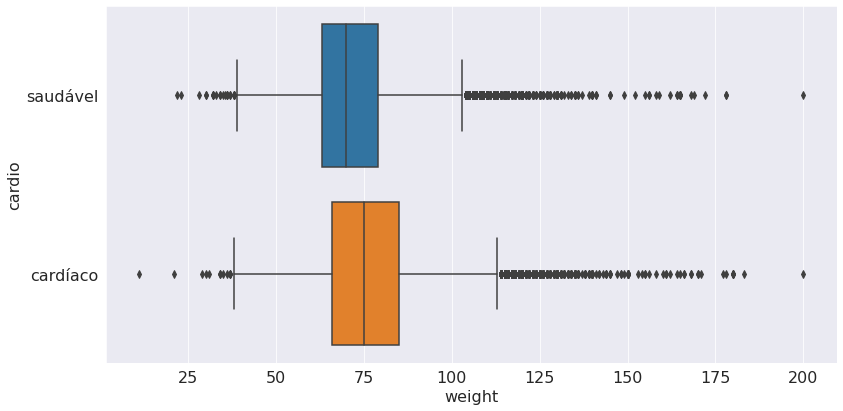

In [174]:
boxplot(df, x='weight', y='cardio', labels=['saudável', 'cardíaco'])

In [175]:
# idade mínima do dataset
df.age.min()

29

Percebe-se que há outliers. Podemos perceber que temos pesos com valores muito elevados e muito baixos - algo muito raro para a idade mínima da distribuição do conjunto de dados. Vamos seguir a mesma técnica que utlizamos anteriormente e remover essas outliers. Dessa vez, vamos considerar até 99.5% do valor de peso máximo e 1% para peso mínimo.

In [176]:
print('99.5% dos valores de weight estão até o valor de {}'.format(df.weight.quantile(0.995)))
print('0.5% dos valores de weight estão até o valor de {}'.format(df.weight.quantile(0.005)))

99.5% dos valores de weight estão até o valor de 124.0
0.5% dos valores de weight estão até o valor de 45.0


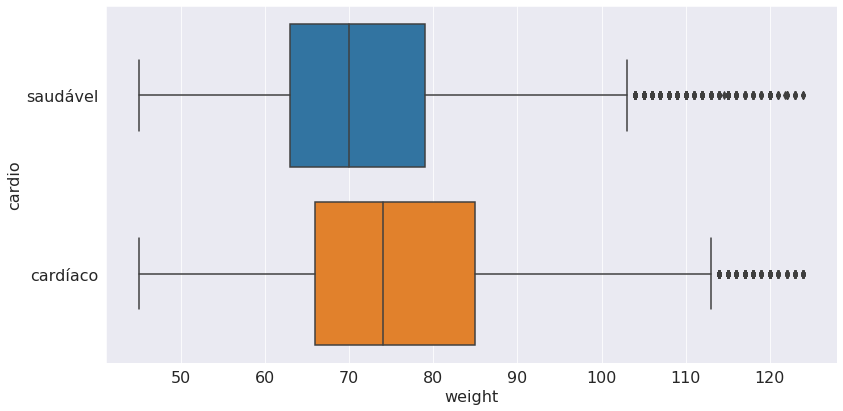

In [177]:
boxplot(df.query('(weight >= 45) and (weight <= 124)'), x='weight', y='cardio', labels=['saudável', 'cardíaco'])

In [178]:
print('shape antes de remover outliers:')
print('linhas:' ,df.shape[0])
print('colunas:' ,df.shape[1])

shape antes de remover outliers:
linhas: 66193
colunas: 13


In [179]:
# ap_lo maiores que 124 e menores que 45 serão eliminados do dataframe original
drop_queries(df, col='weight', lmin=45, lmax=124, inplace=True)

In [180]:
print('shape após remover outliers:')
print('linhas:' ,df.shape[0])
print('colunas:' ,df.shape[1])

shape após remover outliers:
linhas: 65624
colunas: 13


### Variáveis qualitativas

#### Relação entre colesterol e pacientes saudáveis e cardíacos.

1: normal, 2: acima do normal, 3: bem acima do normal

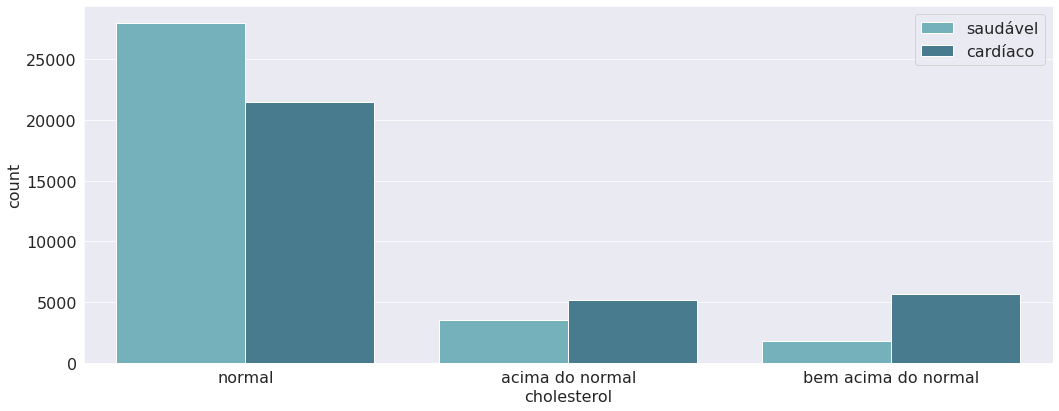

In [181]:
countplot(df, x='cholesterol', labels=['normal', 'acima do normal', 'bem acima do normal'])

✅ Pessoas com colesterol acima do normal tendem a apresentar problemas cardíacos.

#### Relação entre a idade média das pessoas e o índice de colesterol


In [182]:
# 2. Analisando a média, mediana, valores mínimo e máximo de de idade utilizando group by e agg.
df[['cholesterol', 'age']].groupby('cholesterol').agg(['mean', 'median','min','max'])

age               
                  mean median min max
cholesterol                          
1            52.368376     53  29  64
2            53.219224     54  39  64
3            55.736884     57  39  64

A idade média é próxima para ambos os três níveis de colesterol propostos no dataset, entretando temos uma pequena diferença nos valores mínimos de idade. Isso quer dizer que, para esses pacientes, a idade começa a influenciar nos níveis de colesterol à partir de 29 anos.

Quais são os níveis de colesterol de pacientes menores que 39 anos?

In [183]:
df.query('age < 39')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6219,8850,29,1,175,59.0,120,80,1,1,0,0,1,0
22343,31922,29,2,175,92.0,100,60,1,1,0,0,1,0
30666,43842,29,1,159,59.0,120,80,1,1,0,0,1,0
55905,79749,30,1,160,59.0,110,70,1,1,0,0,1,0


Percebemos que nao há muitos pacientes, logo: pelos valores de média e mediana bem próximos, vamos considerar que a idade não está afetando o índice de colesterol para esses pacientes.

✅ Podemos perceber até aqui que a idade **pode ser** fortemente correlacionada com doenças cardiovásculares, assim como o colesterol.

#### Relação entre práticas de exercícios e pacientes cardíacos e saudáveis


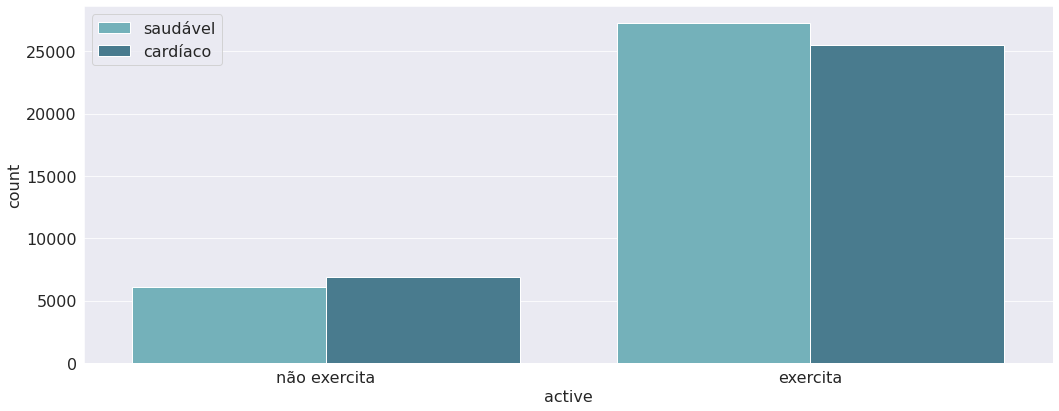

In [184]:
countplot(df, x='active', labels=['não exercita', 'exercita'])

#### Relação entre glucose e pacientes cardíacos e saudáveis

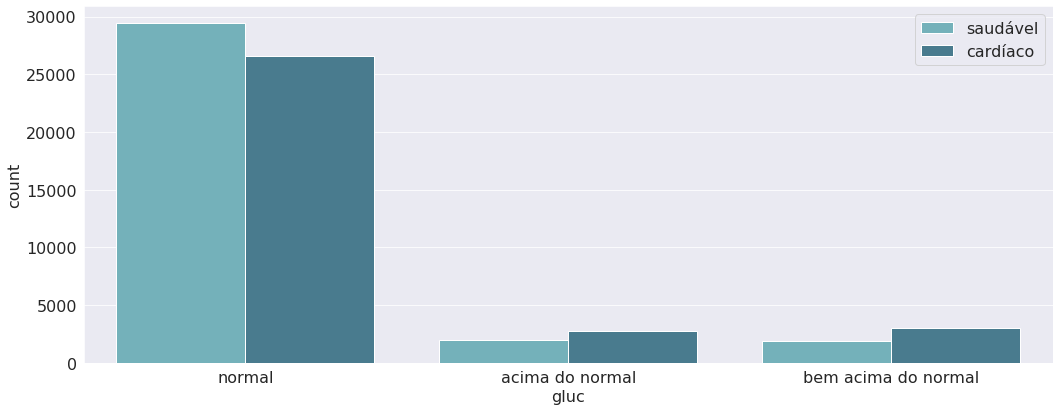

In [185]:
countplot(df, x='gluc', labels=['normal', 'acima do normal', 'bem acima do normal'])

#### Relação entre fumantes e pacientes cardíacos e saudáveis

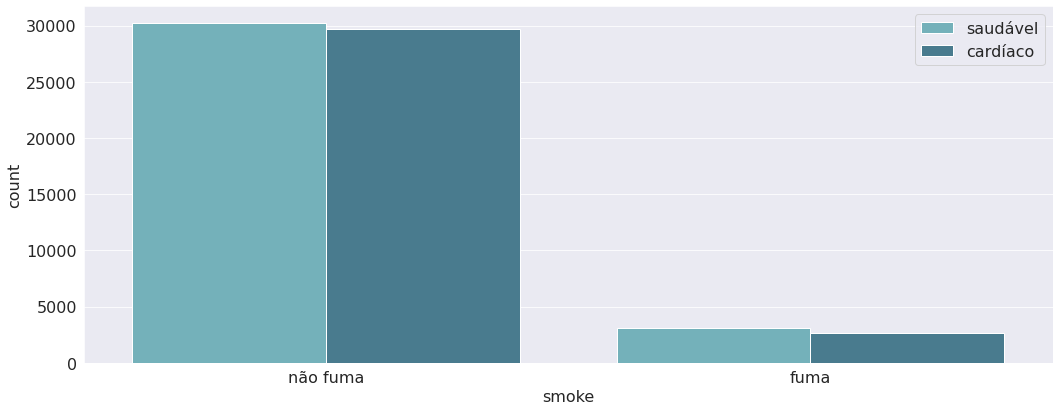

In [186]:
countplot(df, x='smoke', labels=['não fuma', 'fuma'])

### Correlação das váriaveis

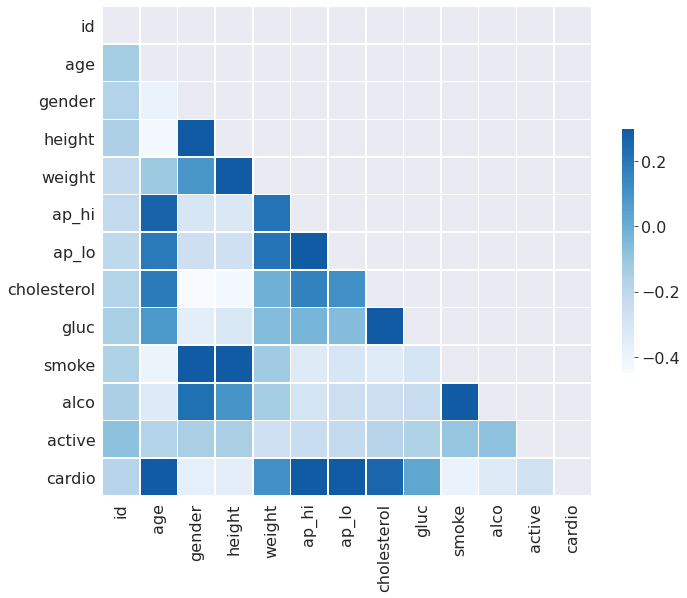

In [187]:
plot_correlation(df.corr())

# MODELOS DE MACHINE LEARNING

In [188]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

## Regressão Logística

In [193]:
df.head(1)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0


In [194]:
X = df.drop(columns=['id', 'cardio' ]).to_numpy()
y = df.cardio.to_numpy()

print(X.shape)
print(y.shape)

(65624, 11)
(65624,)


In [195]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=10)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_val_scaler = scaler.transform(X_val)
X_test_scaler = scaler.transform(X_test)

print('X_train shape {}'.format(X_train_scaler.shape))
print('y_train shape {}'.format(y_train.shape))

print('X_val shape {}'.format(X_val_scaler.shape))
print('y_val shape {}'.format(y_val.shape))

print('X_test shape {}'.format(X_test_scaler.shape))
print('y_test shape {}'.format(y_test.shape))


X_train shape (41999, 11)
y_train shape (41999,)
X_val shape (13125, 11)
y_val shape (13125,)
X_test shape (10500, 11)
y_test shape (10500,)


In [98]:
from sklearn.linear_model import LogisticRegression
# instanciando a função

lamb = 1
maxiter = 200               
model = LogisticRegression(penalty = 'l2', C=1/lamb, max_iter = maxiter)

# treinando
model.fit(X_train_scaler, y_train)

# from sklearn.metrics import mean_squared_error

print(
    'score do conjunto de treinamento: {:.2f}%'.format(
        (model.score(X_train_scaler, y_train)*100))
)

print(
    'score do conjunto de validação: {:.2f}%'.format(
        (model.score(X_val_scaler, y_val)*100))
)
print(
    'score do conjunto de Teste: {:.2f}%'.format(
        model.score(X_test_scaler, y_test)*100)
    )

print(f'número de iterações: {model.n_iter_}')

score do conjunto de treinamento: 72.03%
score do conjunto de validação: 72.47%
score do conjunto de Teste: 72.75%
número de iterações: [12]


ANALISANDO AS FEATURES DE MAIOR CORRELAÇÃO NA FUNÇÃO DE DECISÃO

In [99]:
coeff_df = pd.DataFrame(
    {'features': df.drop(columns=['id', 'cardio' ]).columns}
    )
coeff_df['correlation'] = pd.Series(model.coef_[0])
coeff_df

,features,correlation
0,age,0.354166
1,gender,-0.012526
2,height,-0.028716
3,weight,0.137485
4,ap_hi,0.877655
5,ap_lo,0.088040
6,cholesterol,0.344639
7,gluc,-0.063689
8,smoke,-0.040480
9,alco,-0.056277


<AxesSubplot:xlabel='correlation', ylabel='features'>

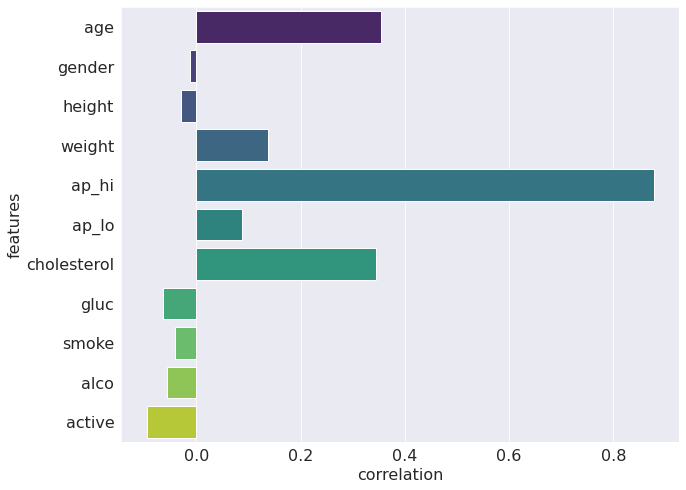

In [100]:
plt.figure(figsize=(10,8))
sns.barplot(data=coeff_df, y='features', x='correlation', palette='viridis')

In [101]:
report = classification_report(y_test, model.predict(X_test_scaler), target_names=['saudável', 'cardíaco'], output_dict=True)
pd.DataFrame(report)

,saudável,cardíaco,accuracy,macro avg,weighted avg
precision,0.706759,0.754657,0.727487,0.730708,0.730369
recall,0.790617,0.662545,0.727487,0.726581,0.727487
f1-score,0.746340,0.705607,0.727487,0.725974,0.726262
support,5158.000000,5014.000000,0.727487,10172.000000,10172.000000


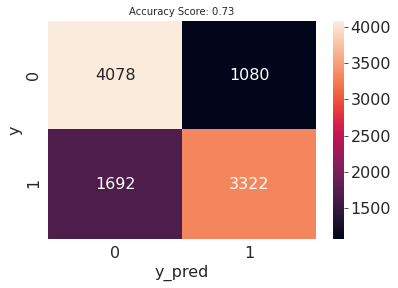

In [102]:
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix

def pvlot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, model.predict(X_test_scaler))

### Aplicando atributos polinomiais

In [109]:
from ipywidgets import interact
from sklearn.preprocessing import PolynomialFeatures

@interact(degree = (0,3,1), maxiter = (100,2000,1))
def train(degree, maxiter):
    global model
    lamb = 1
    poly = PolynomialFeatures(degree = degree)
    model = make_pipeline(poly, LogisticRegression(C=1/lamb, max_iter = maxiter))
    model.fit(X_train_scaler,y_train)    
    #print(model)
    print(
    'score do conjunto de treinamento: {:.2f}%'.format(
        (model.score(X_train_scaler, y_train)*100))
    )

    print(
        'score do conjunto de validação: {:.2f}%'.format(
            (model.score(X_val_scaler, y_val)*100))
    )
    print(
        'score do conjunto de Teste: {:.2f}%'.format(
            model.score(X_test_scaler, y_test)*100)
        )

interactive(children=(IntSlider(value=1, description='degree', max=3), IntSlider(value=1050, description='maxi…

In [110]:
report = classification_report(y_test, model.predict(X_test_scaler), target_names=['saudável', 'cardíaco'], output_dict=True)
pd.DataFrame(report)

,saudável,cardíaco,accuracy,macro avg,weighted avg
precision,0.725181,0.738658,0.731518,0.731919,0.731824
recall,0.757658,0.704627,0.731518,0.731143,0.731518
f1-score,0.741064,0.721241,0.731518,0.731153,0.731293
support,5158.000000,5014.000000,0.731518,10172.000000,10172.000000


recall aumentou de 0.66 para 0.7 - sem aplicar penalidade.

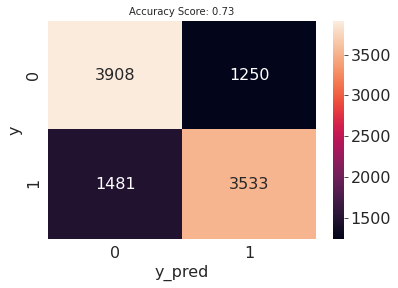

In [112]:
plot_confusion_matrix(y_test, model.predict(X_test_scaler))

TREINANDO COM FEATURES QUE TENHAM CORRELAÇÃO > 0.3, VISANDO AUMENTAR O RECALL E REDUZIR A QUATIDADE DE FALSOS NEGATIVOS.

In [115]:
# X = df[coeff_df[coeff_df.correlation > 0.2].features.values]
X = df.drop(columns = ['gluc','smoke', 'cardio', 'height'])

y = df.cardio

print(X.shape)
print(y.shape)


X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=10)

print('X_train shape {}'.format(X_train.shape))
print('y_train shape {}'.format(y_train.shape))

print('X_val shape {}'.format(X_val.shape))
print('y_val shape {}'.format(y_val.shape))

print('X_test shape {}'.format(X_test.shape))
print('y_test shape {}'.format(y_test.shape))

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_val_scaler = scaler.transform(X_val)
X_test_scaler = scaler.transform(X_test)

# instanciando a função
poly = PolynomialFeatures(degree = 2)
model = make_pipeline(poly, LogisticRegression(C=1/lamb, max_iter = maxiter))

# treinando
model.fit(X_train_scaler, y_train)

# from sklearn.metrics import mean_squared_error

print(
    'score do conjunto de treinamento: {:.2f}%'.format(
        (model.score(X_train_scaler, y_train)*100))
)

print(
    'score do conjunto de validação: {:.2f}%'.format(
        (model.score(X_val_scaler, y_val)*100))
)
print(
    'score do conjunto de Teste: {:.2f}%'.format(
        model.score(X_test_scaler, y_test)*100)
    )

(63572, 9)
(63572,)
X_train shape (40685, 9)
y_train shape (40685,)
X_val shape (12715, 9)
y_val shape (12715,)
X_test shape (10172, 9)
y_test shape (10172,)
score do conjunto de treinamento: 72.58%
score do conjunto de validação: 72.72%
score do conjunto de Teste: 73.23%


In [116]:
report = classification_report(y_test, model.predict(X_test_scaler), target_names=['normal', 'saudável'], output_dict=True)
pd.DataFrame(report)

,normal,saudável,accuracy,macro avg,weighted avg
precision,0.726512,0.738795,0.732304,0.732653,0.732566
recall,0.757076,0.706821,0.732304,0.731949,0.732304
f1-score,0.741479,0.722454,0.732304,0.731967,0.732101
support,5158.000000,5014.000000,0.732304,10172.000000,10172.000000


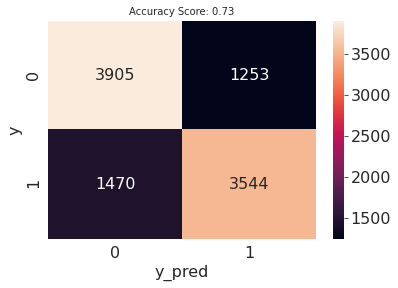

In [117]:
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, model.predict(X_test_scaler))

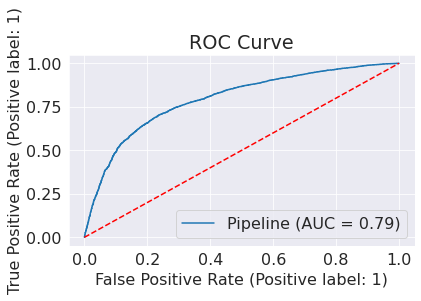

In [118]:
ax = plot_roc_curve(model, X_test_scaler, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.tight_layout()

## grid search e ajuste dos hiperparâmetros

## Linear SVC

In [122]:
# continua...